# Analysis of the paper 'A Watermark for Large Language Models' 

##### Analysis by Harshavardhan Kalalbandi (Harsha) (hkala002@ucr.edu) as a prereq waiver assignment for CS222 NLP with Prof Yue Dong

##### LLM used: Facebook's OPT 1.3B

In [1]:
import torch

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
from transformers import (AutoTokenizer,
                          AutoModelForCausalLM,
                          LogitsProcessorList)

In [14]:
#Import the author's classes. 
#This Notebook must be in the root folder of the author's repo for it to work as intended here without modifications to code

from extended_watermark_processor import WatermarkDetector, WatermarkLogitsProcessor

In [4]:
# Set hardware acceralator
# Requires PyTorch Nightly Version to run on MPS. If Nightly is not installed, run on 'cpu'

device = 'cpu'

if torch.backends.mps.is_available():
    device = torch.device('mps') #Apple Metal Framework for M chips

elif torch.cuda.is_available():
    device = 'cuda' 

print('Hardware accelerator: {}'.format(device))

Hardware accelerator: mps


## Overview: Test the watermark algorithm with default settings

In [16]:
#Initializes the LLM. Runs on 'device' (CPU, CUDA, MPS, etc.). My settings is currently Apple's M2 GPU

model = AutoModelForCausalLM.from_pretrained('facebook/opt-1.3b').to(device) 

In [17]:
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-1.3b')

prompt = (
        "The diamondback terrapin or simply terrapin (Malaclemys terrapin) is a "
        "species of turtle native to the brackish coastal tidal marshes of the "
        "Northeastern and southern United States, and in Bermuda.[6] It belongs "
        "to the monotypic genus Malaclemys. It has one of the largest ranges of "
        "all turtles in North America, stretching as far south as the Florida Keys "
        "and as far north as Cape Cod.[7] The name 'terrapin' is derived from the "
        "Algonquian word torope.[8] It applies to Malaclemys terrapin in both "
        "British English and American English. The name originally was used by "
        "early European settlers in North America to describe these brackish-water "
        "turtles that inhabited neither freshwater habitats nor the sea. It retains "
        "this primary meaning in American English.[8] In British English, however, "
        "other semi-aquatic turtle species, such as the red-eared slider, might "
        "also be called terrapins. The common name refers to the diamond pattern "
        "on top of its shell (carapace), but the overall pattern and coloration "
        "vary greatly. The shell is usually wider at the back than in the front, "
        "and from above it appears wedge-shaped. The shell coloring can vary "
        "from brown to grey, and its body color can be grey, brown, yellow, "
        "or white. All have a unique pattern of wiggly, black markings or spots "
        "on their body and head. The diamondback terrapin has large webbed "
        "feet.[9] The species is"
        )

## 3.1 General verification of soft watermarking algorithm

In [18]:

torch.manual_seed(123) #Seed the RNG before generation

In [19]:
#Arguments for the models generate: method
#Here we are decided whether to use multinomial sampling or beam search

use_sampling = True

gen_kwargs = dict(max_new_tokens=200)

if use_sampling:
    gen_kwargs.update(dict(
        do_sample = True, 
        top_k = 0,
        temperature = 0.7
    ))
else:
    gen_kwargs.update(dict(
        num_beams = 4
    ))

In [20]:
tokd_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True, truncation=True).to(device) #Set the tokenized prompt tensors on the chosen hardware
truncation_warning = True if tokd_input["input_ids"].shape[-1] == 200 else False

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


#### Generate Watermarked text with gamma = 0.25 and delta = 2.0

In [21]:
#DEFAULT CONSTANTS

seeding_scheme = "simple_1"
gamma=0.25
delta=2.0

In [22]:
#Create an object of the Watermark class. 
#Initialize the gamma (green list size) and delta (probability boosting bias) params

watermark_processor = WatermarkLogitsProcessor(vocab=list(tokenizer.get_vocab().values()),
                                               gamma=gamma,
                                               delta=delta,
                                               seeding_scheme=seeding_scheme,
                                               select_green_tokens=True)
                                            

In [129]:
#This method generates the text based on the input (tokenized) prompt
#The watermark_processor object is inserted into the generation pipeline as a Logits Processor

output_with_watermark = model.generate(**tokd_input, 
                                       logits_processor=LogitsProcessorList([watermark_processor]), 
                                       **gen_kwargs)

In [130]:
#The output of the generate: method is decoded using the tokenizer's batch_decode method

decoded_watermark = tokenizer.batch_decode(output_with_watermark, skip_special_tokens=True)[0]

In [131]:
#print(len(decoded_watermark))

#Seed the RNG before detection. Not totally necessary, but good to have
torch.manual_seed(123)

#### Detect the watermarked text

In [132]:
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-1.3b')

watermark_detector = WatermarkDetector(vocab=list(tokenizer.get_vocab().values()),
                                        gamma=gamma,
                                        seeding_scheme=seeding_scheme,
                                        device='mps',
                                        tokenizer=tokenizer,
                                        z_threshold=4.0,
                                        normalizers="",
                                        ignore_repeated_ngrams=False,
                                        select_green_tokens=True)

score_dict = watermark_detector.detect(decoded_watermark)

In [133]:
score_dict

{'num_tokens_scored': 513,
 'num_green_tokens': 167,
 'green_fraction': 0.3255360623781676,
 'z_score': 3.951048749993008,
 'p_value': 3.8904735617074984e-05,
 'z_score_at_T': tensor([-0.5774, -0.8165, -1.0000, -1.1547, -1.2910, -1.4142, -1.5275, -1.6330,
         -1.7321, -1.8257, -1.9149, -1.3333, -0.8006, -0.9258, -1.0435, -1.1547,
         -1.2603, -1.3608, -1.4570, -1.0328, -1.1339, -0.7385, -0.8427, -0.9428,
         -1.0392, -1.1323, -1.2222, -1.3093, -1.3937, -1.4757, -1.1406, -1.2247,
         -1.3065, -0.9901, -0.6831, -0.7698, -0.8542, -0.9366, -0.6472, -0.7303,
         -0.8115, -0.8909, -0.6163, -0.6963, -0.7746, -0.8513, -0.9264, -1.0000,
         -0.7423, -0.8165, -0.8893, -0.9608, -0.7137, -0.4714, -0.5449, -0.6172,
         -0.6882, -0.7581, -0.8268, -0.5963, -0.6653, -0.7332, -0.8001, -0.8660,
         -0.6445, -0.7107, -0.7759, -0.5601, -0.6255, -0.6901, -0.7537, -0.8165,
         -0.8785, -0.9396, -1.0000, -1.0596, -1.1185, -1.1767, -1.2342, -1.2910,
         -1.090

## 3.2 Dependency of Z-score on varying γ and constant δ

Varying Gamma and analyzing its impact

##### Keep Z threshold = 4.0 score and Delta = 2.0 constant and vary Gamma

In [185]:
#Let's play around with Gamma and see what happens to the Z score in the detector. We'll use the same prompt
gamma = 0.25 # now green_list_size = |V| * 0.25 (green list half of vocab size)
delta = 2.0 #Maintaining the same delta
z = 4.0

#Default settings to compare with ^ 

In [23]:
def generate_watermark(prompt=prompt, gamma=0.25, delta=2.0, num_beams=4, use_sampling = True, max_new_tokens=200):

    torch.manual_seed(123)

    #Arguments for the models generate: method
    #Here we are decided whether to use multinomial sampling or beam search

    if use_sampling:
        print('Using multinomial sampling')

    else:
        print('Using beam search with {} beams'.format(num_beams))

    gen_kwargs = dict(max_new_tokens=max_new_tokens)

    if use_sampling:
        gen_kwargs.update(dict(
            do_sample = True, 
            top_k = 0,
            temperature = 0.7
        ))
    else:
        gen_kwargs.update(dict(
            num_beams = num_beams
        ))

    watermark_processor = WatermarkLogitsProcessor(vocab=list(tokenizer.get_vocab().values()),
                                               gamma=gamma,
                                               delta=delta,
                                               seeding_scheme=seeding_scheme,
                                               select_green_tokens=True)
    
    tokd_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True, truncation=True).to(device)
    truncation_warning = True if tokd_input["input_ids"].shape[-1] == 200 else False  
    
    output_with_watermark = model.generate(**tokd_input, 
                                       logits_processor=LogitsProcessorList([watermark_processor]), 
                                       **gen_kwargs)
    
    decoded_watermark = tokenizer.batch_decode(output_with_watermark, skip_special_tokens=True)[0]

    print("Generated watermarked text")

    return decoded_watermark

In [24]:
def detect_watermark(text_to_detect, gamma, z=4.0):

    torch.manual_seed(123)

    tokenizer = AutoTokenizer.from_pretrained('facebook/opt-1.3b') #Reinitializing the tokenizer

    watermark_detector = WatermarkDetector(vocab=list(tokenizer.get_vocab().values()),
                                        gamma=gamma,
                                        seeding_scheme=seeding_scheme,
                                        device='mps',
                                        tokenizer=tokenizer,
                                        z_threshold=z,
                                        normalizers="",
                                        ignore_repeated_ngrams=False,
                                        select_green_tokens=True)
    
    score_dict = watermark_detector.detect(text_to_detect)

    return score_dict

In [177]:
decoded_watermark = generate_watermark(prompt=prompt, gamma=gamma, delta=delta)

Using multinomial sampling
Generated watermarked text


In [179]:
score_dict = detect_watermark(text_to_detect=decoded_watermark, gamma=gamma, z=4.0)

In [180]:
score_dict

{'num_tokens_scored': 513,
 'num_green_tokens': 167,
 'green_fraction': 0.3255360623781676,
 'z_score': 3.951048749993008,
 'p_value': 3.8904735617074984e-05,
 'z_score_at_T': tensor([-0.5774, -0.8165, -1.0000, -1.1547, -1.2910, -1.4142, -1.5275, -1.6330,
         -1.7321, -1.8257, -1.9149, -1.3333, -0.8006, -0.9258, -1.0435, -1.1547,
         -1.2603, -1.3608, -1.4570, -1.0328, -1.1339, -0.7385, -0.8427, -0.9428,
         -1.0392, -1.1323, -1.2222, -1.3093, -1.3937, -1.4757, -1.1406, -1.2247,
         -1.3065, -0.9901, -0.6831, -0.7698, -0.8542, -0.9366, -0.6472, -0.7303,
         -0.8115, -0.8909, -0.6163, -0.6963, -0.7746, -0.8513, -0.9264, -1.0000,
         -0.7423, -0.8165, -0.8893, -0.9608, -0.7137, -0.4714, -0.5449, -0.6172,
         -0.6882, -0.7581, -0.8268, -0.5963, -0.6653, -0.7332, -0.8001, -0.8660,
         -0.6445, -0.7107, -0.7759, -0.5601, -0.6255, -0.6901, -0.7537, -0.8165,
         -0.8785, -0.9396, -1.0000, -1.0596, -1.1185, -1.1767, -1.2342, -1.2910,
         -1.090

### Low Gamma and high Delta

#### The paper states that we can achieve a very strong watermark from a low gamma value (smaller greenlist size) and a higher bias (delta)

In [181]:
gamma = 0.10
delta = 5.0

In [182]:
decoded_watermark = generate_watermark(prompt=prompt, gamma=gamma, delta=delta)

Using multinomial sampling
Generated watermarked text


In [183]:
score_dict = detect_watermark(text_to_detect=decoded_watermark, gamma=gamma, z=4.0)

In [184]:
score_dict #Observation - a very high Z score indicating a stronger watermark.

{'num_tokens_scored': 513,
 'num_green_tokens': 178,
 'green_fraction': 0.3469785575048733,
 'z_score': 18.646472182237893,
 'p_value': 6.744474686614525e-78,
 'z_score_at_T': tensor([-0.3333, -0.4714, -0.5774, -0.6667, -0.7454, -0.8165, -0.8819, -0.9428,
         -1.0000, -1.0541, -1.1055, -1.1547, -1.2019, -1.2472, -1.2910, -1.3333,
         -1.3744, -1.4142, -1.4530, -1.4907, -1.5275, -0.8528, -0.9036, -0.9526,
         -1.0000, -1.0460, -1.0906, -1.1339, -1.1761, -1.2172, -0.6586, -0.7071,
         -0.7543, -0.8003, -0.8452, -0.8889, -0.9316, -0.9733, -0.4804, -0.5270,
         -0.5726, -0.6172, -0.6608, -0.7035, -0.7454, -0.7864, -0.8266, -0.8660,
         -0.4286, -0.4714, -0.5134, -0.5547, -0.5952, -0.6351, -0.6742, -0.7127,
         -0.7506, -0.7878, -0.8245, -0.4303, -0.4695, -0.5080, -0.5459, -0.5833,
         -0.6202, -0.6565, -0.6923, -0.7276, -0.7624, -0.7968, -0.8307, -0.8642,
         -0.8973, -0.9300, -0.9623, -0.9941, -1.0256, -1.0568, -1.0876, -1.1180,
         -0.777

### Maintain the low Gamma and high Delta, and now use Beam Search and validate the author's claim of Z score increase

#### Z score increases when beam search is used. 
##### Using beam search, the z score jumped from 3.9x to 10.x on the baseline gamma and delta. The watermarking appears to be stronger (higher confidence score).

##### Let's try with 4 and 8 beams..

##### 4 beams - z_score: 10.57, 8 beams - z_score: 7.82

In [192]:
#Try beam search (4 beams) with gamma = 0.25 and delta = 2.0 (baseline settings)
decoded_watermark = generate_watermark(prompt=prompt, gamma=0.25, delta=2.0, num_beams=8, use_sampling=False)

Using beam search with 8 beams
Generated watermarked text


In [193]:
score_dict = detect_watermark(text_to_detect=decoded_watermark, gamma=0.25, z=4.0)

In [194]:
score_dict

{'num_tokens_scored': 513,
 'num_green_tokens': 205,
 'green_fraction': 0.3996101364522417,
 'z_score': 7.825625588695829,
 'p_value': 2.525693143744072e-15,
 'z_score_at_T': tensor([-0.5774, -0.8165, -1.0000, -1.1547, -1.2910, -1.4142, -1.5275, -1.6330,
         -1.7321, -1.8257, -1.9149, -1.3333, -0.8006, -0.9258, -1.0435, -1.1547,
         -1.2603, -1.3608, -1.4570, -1.0328, -1.1339, -0.7385, -0.8427, -0.9428,
         -1.0392, -1.1323, -1.2222, -1.3093, -1.3937, -1.4757, -1.1406, -1.2247,
         -1.3065, -0.9901, -0.6831, -0.7698, -0.8542, -0.9366, -0.6472, -0.7303,
         -0.8115, -0.8909, -0.6163, -0.6963, -0.7746, -0.8513, -0.9264, -1.0000,
         -0.7423, -0.8165, -0.8893, -0.9608, -0.7137, -0.4714, -0.5449, -0.6172,
         -0.6882, -0.7581, -0.8268, -0.5963, -0.6653, -0.7332, -0.8001, -0.8660,
         -0.6445, -0.7107, -0.7759, -0.5601, -0.6255, -0.6901, -0.7537, -0.8165,
         -0.8785, -0.9396, -1.0000, -1.0596, -1.1185, -1.1767, -1.2342, -1.2910,
         -1.0906

### Now let's keep delta at 5 amd vary Gamma from 0.1 to 0.9 (0.1, 0.25, 0.5, 0.75, 0.9) on a 4 way beam search
#### While also varying token size T (max_new_tokens) from 50 to 200 in steps of 50

In [34]:
def test_z_beam(delta, gammas, num_beams=4):
    
    res = []

    for max_new_tokens in range(50, 201, 50):

        for gamma in gammas:
            score_dicts = {}
            
            decoded_watermark = generate_watermark(prompt=prompt, gamma=gamma, delta=delta, num_beams=num_beams, use_sampling=False, max_new_tokens=max_new_tokens)
            score_dict = detect_watermark(text_to_detect=decoded_watermark, gamma=gamma, z=4.0)

            score_dicts['gamma'] = gamma
            score_dicts['token_size'] = max_new_tokens
            score_dicts['delta'] = delta
            score_dicts['z_score'] = score_dict['z_score']
            score_dicts['p_value'] = score_dict['p_value']
            score_dicts['num_tokens_scored'] = score_dict['num_tokens_scored']
            score_dicts['num_green_tokens'] = score_dict['num_green_tokens']

            res.append(score_dicts)

    return res

In [35]:
#Originally delta = 5, gammas=[0.1, 0.25, 0.5, 0.75, 0.9]
# To test for lower values, delta = 1.5, gammas = [0.05, 0.1, 0.15, 0.20, 0.25]

#The lower delta and gammas was chosen to test the impact of lower values on the Z score. 
#Replace them with original values if and when needed

res = test_z_beam(delta=1.5, gammas=[0.05, 0.1, 0.15, 0.20, 0.25], num_beams=4)

Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam search with 4 beams
Generated watermarked text
Using beam sea

In [36]:
#Convert the results dict into a Pandas dataframe. Store and access whenever needed

df = pd.DataFrame(res)
df

,gamma,token_size,delta,z_score,p_value,num_tokens_scored,num_green_tokens
0,0.05,50,1.5,-0.517772,6.976912e-01,363,16
1,0.10,50,1.5,-1.277169,8.992287e-01,363,29
2,0.15,50,1.5,-0.213137,5.843901e-01,363,53
3,0.20,50,1.5,-1.390889,9.178705e-01,363,62
4,0.25,50,1.5,0.393939,3.468129e-01,363,94
5,0.05,100,1.5,1.207903,1.135423e-01,413,26
6,0.10,100,1.5,1.919065,2.748808e-02,413,53
7,0.15,100,1.5,1.522762,6.390907e-02,413,73
8,0.20,100,1.5,0.049207,4.803773e-01,413,83
9,0.25,100,1.5,2.698907,3.478379e-03,413,127


In [37]:
#Store the results locally.

df.to_csv('./fig3_beams_low_gammas.csv') #This file is used for storing results of lower params test

In [38]:
df = pd.read_csv('./fig3_beams_low_gammas.csv')
df

#df.drop(columns=['Unnamed:0.1', 'Unnamed:0'])

,Unnamed: 0,gamma,token_size,delta,z_score,p_value,num_tokens_scored,num_green_tokens
0,0,0.05,50,1.5,-0.517772,6.976912e-01,363,16
1,1,0.10,50,1.5,-1.277169,8.992287e-01,363,29
2,2,0.15,50,1.5,-0.213137,5.843901e-01,363,53
3,3,0.20,50,1.5,-1.390889,9.178705e-01,363,62
4,4,0.25,50,1.5,0.393939,3.468129e-01,363,94
5,5,0.05,100,1.5,1.207903,1.135423e-01,413,26
6,6,0.10,100,1.5,1.919065,2.748808e-02,413,53
7,7,0.15,100,1.5,1.522762,6.390907e-02,413,73
8,8,0.20,100,1.5,0.049207,4.803773e-01,413,83
9,9,0.25,100,1.5,2.698907,3.478379e-03,413,127


### Plotting low gammas and low delta

[]

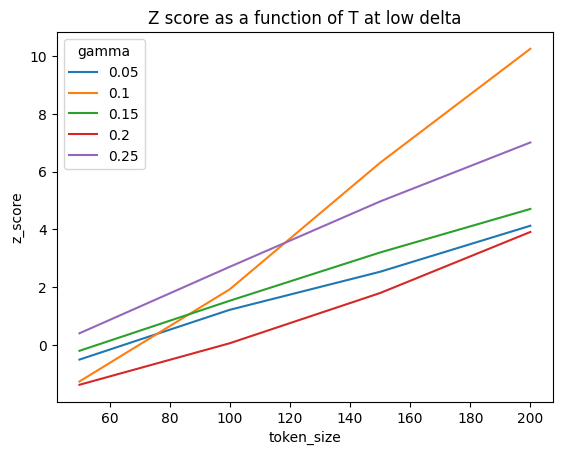

In [39]:
T = [50, 100, 150, 200]
g = [0.05, 0.1, 0.15, 0.20, 0.25]

palette_colors = sns.color_palette('tab10')
palette_dict = {gamma: color for gamma, color in zip(g, palette_colors)}

for g_ in g:
    z_ = df[df['gamma'] == g_]
    sns.lineplot(data=z_, x=z_.token_size, y=z_.z_score, hue='gamma', palette=palette_dict).set_title('Z score as a function of T at low delta')

plt.plot()

#### Plotting the dependence of Z score on green list size parameter (gamma) with constant delta using a 4 way beam search

In [ ]:
#Call this method when the previous cells are run with the original values of gamma and delta

T = [50, 100, 150, 200]
d = [5,5,5,5,5]
g = [0.10, 0.25, 0.50, 0.75, 0.90]

palette_colors = sns.color_palette('tab10')
palette_dict = {gamma: color for gamma, color in zip(g, palette_colors)}

for g_ in g:
    z_ = df[df['gamma'] == g_]
    sns.lineplot(data=z_, x=z_.token_size, y=z_.z_score, hue='gamma', palette=palette_dict).set_title('Z score as a function of T at delta = 5')

plt.plot()

#### Using multinomial sampling with delta = 5

In [43]:
def test_z_sampling(delta, gammas):
    
    res = []

    for max_new_tokens in range(50, 201, 50):

        for gamma in gammas:
            score_dicts = {}
            
            decoded_watermark = generate_watermark(prompt=prompt, gamma=gamma, delta=delta, use_sampling=True, max_new_tokens=max_new_tokens)
            score_dict = detect_watermark(decoded_watermark, gamma, delta)

            score_dicts['gamma'] = gamma
            score_dicts['token_size'] = max_new_tokens
            score_dicts['delta'] = delta
            score_dicts['z_score'] = score_dict['z_score']
            score_dicts['p_value'] = score_dict['p_value']
            score_dicts['num_tokens_scored'] = score_dict['num_tokens_scored']
            score_dicts['num_green_tokens'] = score_dict['num_green_tokens']

            res.append(score_dicts)

    return res

In [44]:
res = test_z_sampling(delta=5, gammas=[0.1, 0.25, 0.5, 0.75, 0.9])

Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
G

In [47]:
df = pd.DataFrame(res)
df.to_csv('./fig3_sampling.csv')

In [48]:
#Use this cell if the df is already saved as CSV in the above cell

df = pd.read_csv('./fig3_beams.csv')
df

,Unnamed: 0,gamma,token_size,delta,z_score,p_value,num_tokens_scored,num_green_tokens
0,0,0.10,50,5,5.196152,1.017277e-07,363,66
1,1,0.25,50,5,2.818182,2.414823e-03,363,114
2,2,0.50,50,5,3.306642,4.721066e-04,363,213
3,3,0.75,50,5,1.303030,9.628221e-02,363,283
4,4,0.90,50,5,0.927260,1.768959e-01,363,332
5,5,0.10,100,5,12.416512,1.063162e-35,413,117
6,6,0.25,100,5,6.903521,2.536466e-12,413,164
7,7,0.50,100,5,5.560366,1.346044e-08,413,263
8,8,0.75,100,5,2.616849,4.437285e-03,412,332
9,9,0.90,100,5,1.689433,4.556825e-02,413,382


[]

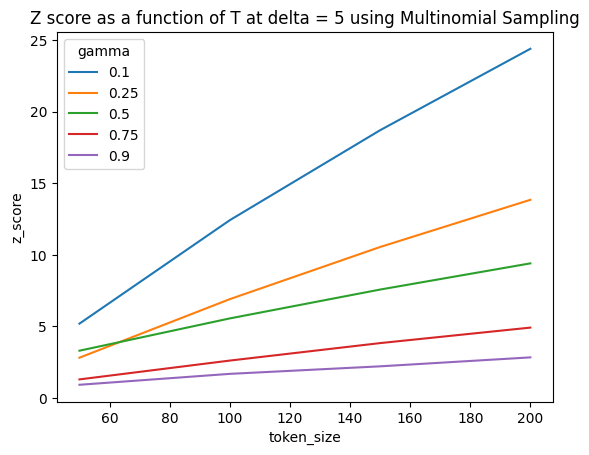

In [49]:
T = [50, 100, 150, 200]
d = [5,5,5,5,5]
g = [0.1, 0.25, 0.50, 0.75, 0.90]

palette_colors = sns.color_palette('tab10')
palette_dict = {gamma: color for gamma, color in zip(g, palette_colors)}

for g_ in g:
    z_ = df[df['gamma'] == g_]
    sns.lineplot(data=z_, x=z_.token_size, y=z_.z_score, hue='gamma', palette=palette_dict).set_title('Z score as a function of T at delta = 5 using Multinomial Sampling')

plt.plot()

## 3.3 Dependency of Z score on varying δ and constant γ

### Using multinomial sampling

In [50]:
def test_z_sampling(deltas, gamma):
    
    res = []

    for max_new_tokens in range(50, 201, 50):

        gen_kwargs = dict(max_new_tokens=max_new_tokens)

        gen_kwargs.update(dict(
            do_sample = True, 
            top_k = 0,
            temperature = 0.7
         ))

        for delta in deltas:
            score_dicts = {}
            
            decoded_watermark = generate_watermark(prompt=prompt, gamma=gamma, delta=delta, use_sampling=True, max_new_tokens=max_new_tokens)
            score_dict = detect_watermark(decoded_watermark, gamma, delta)

            score_dicts['gamma'] = gamma
            score_dicts['token_size'] = max_new_tokens
            score_dicts['delta'] = delta
            score_dicts['z_score'] = score_dict['z_score']
            score_dicts['p_value'] = score_dict['p_value']
            score_dicts['num_tokens_scored'] = score_dict['num_tokens_scored']
            score_dicts['num_green_tokens'] = score_dict['num_green_tokens']

            res.append(score_dicts)

    return res

In [51]:
deltas = [0.5, 1, 2, 5, 10]
res = test_z_sampling(deltas, gamma=0.25) #Gamma = [0.25, 0.5] low and high range

Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
Generated watermarked text
Using multinomial sampling
G

In [52]:
df = pd.DataFrame(res)
df.to_csv('./fig3_sampling_delta.csv')

In [53]:
#Use this cell if the df is already saved as CSV in the above cell

df = pd.read_csv('./fig3_sampling_delta.csv')
df

,Unnamed: 0,gamma,token_size,delta,z_score,p_value,num_tokens_scored,num_green_tokens
0,0,0.25,50,0.5,-1.545455,9.388818e-01,363,78
1,1,0.25,50,1.0,-0.575758,7.176105e-01,363,86
2,2,0.25,50,2.0,0.515152,3.032236e-01,363,95
3,3,0.25,50,5.0,2.002761,2.260150e-02,362,107
4,4,0.25,50,10.0,1.493098,6.770581e-02,359,102
5,5,0.25,100,0.5,-0.937515,8.257532e-01,413,95
6,6,0.25,100,1.0,-0.596601,7.246129e-01,413,98
7,7,0.25,100,2.0,2.471631,6.724917e-03,413,125
8,8,0.25,100,5.0,5.382453,3.673873e-08,411,150
9,9,0.25,100,10.0,4.905779,4.652865e-07,405,144


#### Plot curve for Z score

[]

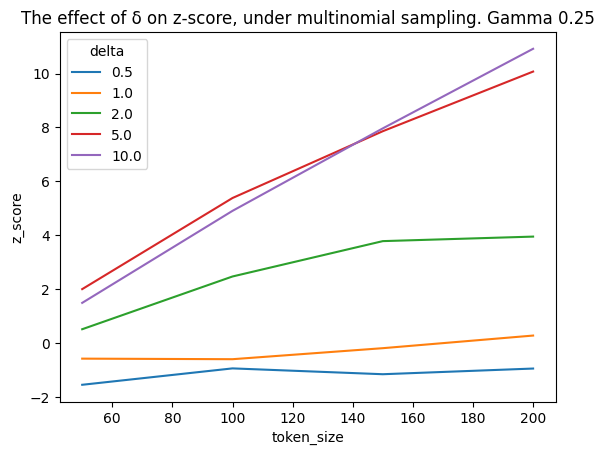

In [54]:
T = [50, 100, 150, 200]
deltas = [0.5, 1, 2, 5, 10]

palette_colors = sns.color_palette('tab10')
palette_dict = {delta: color for delta, color in zip(deltas, palette_colors)}

for d in deltas:
    z_ = df[df['delta'] == d]
    sns.lineplot(data=z_, x=z_.token_size, y=z_.z_score, hue='delta', palette=palette_dict).set_title('The effect of δ on z-score, under multinomial sampling. Gamma 0.25')

plt.plot()

### Vary delta keeping gamma constant using 4-way beam search

In [55]:
def test_z_beam(deltas, gamma, num_beams=4):
    
    res = []

    for max_new_tokens in range(50, 201, 50):

        gen_kwargs = dict(max_new_tokens=max_new_tokens)

        gen_kwargs.update(dict(
            num_beams = 4
        ))

        for delta in deltas:
            score_dicts = {}
            
            decoded_watermark = generate_watermark(prompt=prompt, gamma=gamma, delta=delta, num_beams=num_beams, use_sampling=False, max_new_tokens=max_new_tokens)
            score_dict = detect_watermark(decoded_watermark, gamma, delta)

            score_dicts['gamma'] = gamma
            score_dicts['token_size'] = max_new_tokens
            score_dicts['delta'] = delta
            score_dicts['z_score'] = score_dict['z_score']
            score_dicts['p_value'] = score_dict['p_value']
            score_dicts['num_tokens_scored'] = score_dict['num_tokens_scored']
            score_dicts['num_green_tokens'] = score_dict['num_green_tokens']

            res.append(score_dicts)

    return res

In [ ]:
deltas = [0.5, 1, 2, 5, 10]
res = test_z_beam(deltas=deltas, gamma=0.10, num_beams=4) #gamma was 0.25 before. Testing lower param values. 

In [ ]:
df = pd.DataFrame(res)
df.to_csv('./fig3_beam_g_0.10_delta.csv') #./fig3_beam_delta.csv

In [ ]:
# Print Z as a function of delta for Gamma = [0.10, 0.25]
df_z = df[df['token_size'] == 200]

df2 = pd.read_csv('./fig3_beam_delta.csv')
df2_z = df2[df2['token_size'] == 200] #dataframe that contained values for different deltas at gamma = 0.25

df2_z

In [ ]:
gammas = [0.10, 0.25]

df_arr = [df_z, df2_z]

palette_colors = sns.color_palette('tab10')

palette_dict = {gamma: color for gamma, color in zip(gammas, palette_colors)}

sns.lineplot(data=df2_z, x='delta', y='z_score', hue='gamma', palette=palette_dict)
sns.lineplot(data=df_z, x='delta', y='z_score', hue='gamma', palette=palette_dict)

plt.title('Z score as a function of delta')
plt.plot()

In [ ]:
T = [50, 100, 150, 200]
deltas = [0.5, 1, 2, 5, 10]

palette_colors = sns.color_palette('tab10')
palette_dict = {delta: color for delta, color in zip(deltas, palette_colors)}

#print(palette_dict)

for d in deltas:
    z_ = df[df['delta'] == d]
    sns.lineplot(data=z_, x=z_.token_size, y=z_.z_score, hue='delta', palette=palette_dict).set_title('The effect of δ on z-score under 4-way beam search. Gamma 0.5')

plt.plot()

### Plot Z score as a function of Delta at T = 200

In [ ]:
df_z.drop(columns=['Unnamed: 0'])

In [ ]:
sns.lineplot(data=df_z, x=df_z.delta, y=df_z.z_score).set_title("Z score as a function of delta. Gamma 0.25")

### Test different prompts

In [ ]:
data = './data.txt' #Wikipedia entries

f = open(data, 'r')

prompt1 = ''

for line in f:
    prompt1 += line

prompts = prompt1.split('\n')

print(prompts)

In [ ]:
#Generate for half prompts without watermark
#Generate for half with watermark

In [ ]:
watermark_prompts = prompts[:len(prompts) // 2]
unwatermarked_prompts = prompts[len(prompts) // 2: len(prompts)]

In [ ]:
watermarked_outputs = []
unwatermarked_outputs = []
scores = []

In [ ]:
for p in watermark_prompts:
    watermarked_output = generate_watermark(prompt=p, gamma=0.25, delta=5.0)#gamma=0.25, delta=2.0
    watermarked_outputs.append(watermarked_output)

In [ ]:
for marked in watermarked_outputs:
    score = detect_watermark(marked, gamma=0.25, z=4.0)
    scores.append(score)
    print(score['z_score'])

In [ ]:
f = open('./true.txt', 'w')

for marked in watermarked_outputs:
    f.write(marked)

f.close()

### Test the model for unwatermarked and watermarked texts

##### Generate a few examples without watermark, and few samples with watermark. Model used will be constant

In [ ]:
def generate_without_watermark(prompt):
    
    tokd_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True, truncation=True).to(device)
    truncation_warning = True if tokd_input["input_ids"].shape[-1] == 200 else False  
    
    output_with_watermark = model.generate(**tokd_input)
    
    unwatermarked = tokenizer.batch_decode(output_with_watermark, skip_special_tokens=True)[0]

    return unwatermarked

In [ ]:
unwatermarked = generate_without_watermark(prompt=prompt)
print(unwatermarked)

In [ ]:
score_dict = detect_watermark(unwatermarked, 0.25, 4)

In [ ]:
score_dict